# Getting Started: Preprocessing
In this notebook, we will illustrate how to prepare the target protein structure for the subpocket-based docking pipeline. This includes: 
1. fetching the pdb of interest, 
2. removing waters, and small molecules, 
3. determing the binding pocket, 
4. and lastely, defining the binding pocket and subpockets in SeeSAR. 

As a result, we will generate subpocket-specific definition files that will be later used within the subpocket-based docking pipeline for FlexX docking and HYDE scoring.
As a small example, we will do this on the hamster kinase PKA (PDB: 5n1f) that also places a role in various cancer. 

In [ ]:
# imports
from Bio import PDB
from Bio.PDB import PDBIO
import nglview

## Fetch the PDB structure
Within this tutorial, we will apply the subpocket-based docking pipeline on a hamster PKA (PDB: `5n1f`). Thus, we first need to retrieve it from the PDB.

In [2]:
pdb_id = "5N1F"

**Note:** due to a version clash of openCADD with Biopython, the required Biopython version needs to be installed manually. Please run 
```bash
pip install biopython==1.85
```
in the terminal, or run the following cell:

In [9]:
!pip install biopython==1.85

In [6]:
pdbl = PDB.PDBList(server="https://files.wwpdb.org")
pdb_filename = pdbl.retrieve_pdb_file(pdb_id, file_format="pdb")
structure = PDB.PDBParser().get_structure(pdb_id, pdb_filename)

Structure exists: '/Users/katharinabuchthal/hiwi/KinFragLib_PocketEnum/notebooks/n1/pdb5n1f.ent' 


In [7]:
view = nglview.show_biopython(structure)
view.add_representation('licorice',selection="water")
view

NGLWidget()

In [8]:
_ = view.render_image(trim=True, factor=2)

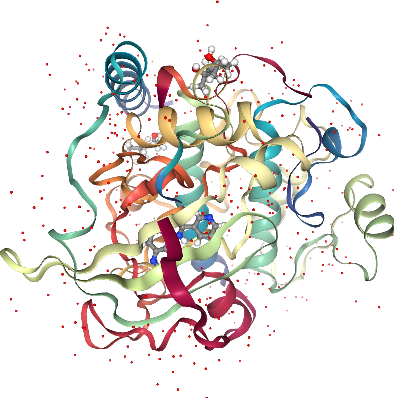

In [9]:
view._display_image()

## Remove waters and small molecules
Since water and small molecules can occupy the binding pocket - which could prevent the growing ligands to be docked there - we remove them. Here, we first remove waters, and then small molecules. Since some waters can also be part of water bridges, we keep the three preserved waters: 686, 691, 696.

In [10]:
preserved_waters = {686, 691, 696}

In [11]:
for chain in structure.get_chains():
    # here we iterate to make it applicable to other structure but this one has only one chain
    water_to_rm = []
    for res in chain:    
        if res.resname == 'HOH':
            if res.id[1] not in preserved_waters:
                water_to_rm.append(res.id)
            else:
                print(f"Water {res.id[1]} is preserved")

    for water_id in water_to_rm:
        chain.detach_child(water_id)

Water 686 is preserved
Water 691 is preserved
Water 696 is preserved


In [12]:
view = nglview.show_biopython(structure)
view.add_representation('licorice',selection="water")
view

NGLWidget()

In [13]:
_ = view.render_image(trim=True, factor=2)

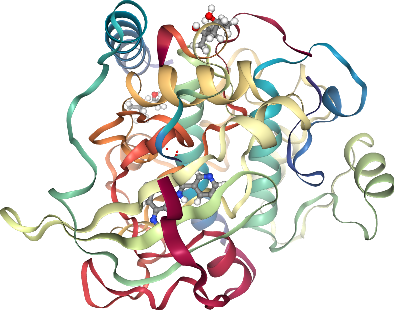

In [14]:
view._display_image()

We see, that all waters - except three - are removed now. However, there are still two small molecules (8ET, MPD) that need to be removed:

In [15]:
partitions = set(res.id[0] for res in structure.get_residues())
partitions

{' ', 'H_8ET', 'H_MPD', 'H_SEP', 'H_TPO', 'W'}

Only 'H_8ET' and 'H_MPD' are ligands, SEP and TPO are modified residues

In [16]:
ligands = {'H_8ET', 'H_MPD'}

In [17]:
for chain in structure.get_chains():
    # here we iterate to make it applicable to other structrure but this one has only one chain
    ligand_res_ids = []
    for res in chain:    
        if res.id[0] in ligands:
            ligand_res_ids.append(res.id)

    for ligand_id in ligand_res_ids:
        chain.detach_child(ligand_id)

In [18]:
view = nglview.show_biopython(structure)
view.add_representation('licorice',selection="water")
view

NGLWidget()

In [19]:
_ = view.render_image(trim=True, factor=2)

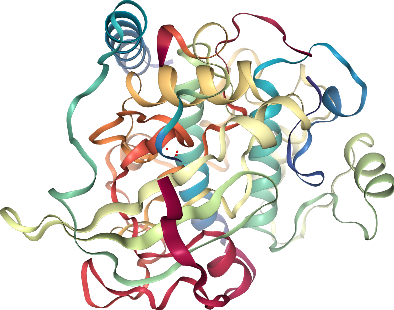

In [20]:
view._display_image()

Now, the protein structure is ready. We will save it to a pdb file for the following steps.

In [21]:
io = PDBIO()
io.set_structure(structure)
io.save("5n1f_preprocessed.pdb")

### Binding pocket defintion 
Our target protein structure 5N1F is a hamster PKA and thus not listed in KLIFS. Since, we cannot directly retrive the binding pocket residues from KLIFS, and need to determine the 85 binding pocket residues from a multiple sequence alignemnt of known PKA strcutures. To this end, we employ the [pocket_definition](../pocket_definition/pocket_definition.py) script.

Before continuing, please make sure to install necessary software (specified in [README](../pocket_definition/README.md)).

In [ ]:
%run -i '../pocket_definition/pocket_definition.py' '-f=PKA' '-n=Prkaca' '-p=5n1f_preprocessed.pdb'

FileNotFoundError: [Errno 2] No such file or directory: 'clustalo'

We now determined the 85 KLIFS subpocket residues (Mapping Residue ID) and need to define them in **SeeSAR** to make them available for FlexX. To this end, we need to perform the following steps
1. Load `5n1f_preprocessed.pdb` into SeeSAR and open the binding side mode
2. To define the binding pocket, add every binding site residue (`Residue ID`, determined in the last cell) to the binding side, i.e., right click on a residue + 'Add Residue the Binding Site':

<img src="images/add_residue_binding_site.png">

3. After having added all resiudes to the binding site, we need to confirm the selection:

<img src="images/conform_selection.png">

Now, it should state that the binding site contains **85** residues, indicating that we succesfully defined the binding pocket.

<img src="images/binding_pocket_defined.png">

However, we still need to define the subpockets.

### Subpocket Defintion
To define the individual subpockets as pharmacophores in **SeeSAR**, we proceed in the same project as used in the previous step. We recall the subpocket-specific anchor residues that we will use to center the pharmocophores to the subpoekct centers:

In [27]:
%run -i '../pocket_definition/pocket_definition.py' '-f=PKA' '-n=Prkaca' '-p=5n1f_preprocessed.pdb'

2025-06-04 11:36:37 - INFO - Proceed chain A
2025-06-04 11:36:37 - INFO - Alignment found (score: 319.0):
	KTLGTGSFGRVML---------YAMKIL------------HTLNEKRILQAVN-PFLVKLEFS-------YMVMEYVAGGEMFSHLRR--------------------YLHSLDLIYRDLKPENLLI-------VTDFGFA
	KTLGTGSFGRVMLVKHKETGNHYAMKILDKQKVVKLKQIEHTLNEKRILQAVNFPFLVKLEFSFKDNSNLYMVMEYVPGGEMFSHLRRIGRFEPHARFYAAQIVLTFEYLHSLDLIYRDLKPENLLIDQQGYIQVTDFGFA



Mapping 	| KLIFS numbering 	|
		| Residue ID 		|

| 1	| 2	| 3	| 4	| 5	| 6	| 7	| 8	| 9	| 10	| 11	| 12	| 13	| 14	| 15	|
| 47	| 48	| 49	| 50	| 51	| 52	| 53	| 54	| 55	| 56	| 57	| 58	| 59	| 69	| 70	|

| 16	| 17	| 18	| 19	| 20	| 21	| 22	| 23	| 24	| 25	| 26	| 27	| 28	| 29	| 30	|
| 71	| 72	| 73	| 74	| 87	| 88	| 89	| 90	| 91	| 92	| 93	| 94	| 95	| 96	| 97	|

| 31	| 32	| 33	| 34	| 35	| 36	| 37	| 38	| 39	| 40	| 41	| 42	| 43	| 44	| 45	|
| 98	| 99	| 101	| 102	| 103	| 104	| 105	| 106	| 107	| 108	| 109	| 117	| 118	| 119	| 120	|

| 46	| 47	| 48	| 49	| 50	| 51	| 52	| 53	| 54	| 55	| 56	| 57	| 58	| 59	| 60	|
| 121	| 122	| 123	| 124	| 125	| 126	| 127	| 128	| 129	| 130	| 131	| 132	| 133	| 134	| 156	|

| 61	| 62	| 63	| 64	| 65	| 66	| 67	| 68	| 69	| 70	| 71	| 72	| 73	| 74	| 75	|
| 157	| 158	| 159	| 160	| 161	| 162	| 163	| 164	| 165	| 166	| 167	| 168	| 169	| 170	| 171	|

| 76	| 77	| 78	| 79	| 80	| 81	| 82	| 83	| 84	| 85	|
| 172	| 173	| 174	| 182	| 183	| 184	| 185	| 186	| 187	| 188	|

Subpocket residues:
Hinge

The residue ID of the anchor residues are listed in the `[`-brackets.

In SeeSAR, we first switch to the docking mode keeping the protein with its defined binding pocket. In this tutorial, we only consider the subpockets AP, FP, and GA. Let's start by creating the pharmacophore constraint for the AP subpocket.

#### Creating the subpocket-specific pharmacophores
The AP subpocket comprises the hinge region. Most kinase inhibitors form one or two hydrogen bonds at this site, anchoring the ligand in the binding pocket. Thus, we want to encourage the AP fragments to form a similar hydrogen bond. Therefore, for the AP pharmacophore we set the contraint 'acceptors or donors' (see the following image) and use a radius of 3.5Å. To center the pharmacophore, we select the $C_\alpha$-atoms of the two hinge residues (here residue 123 and 125) by clicking on them (both of these atoms should be displayed as small pink spheres now, see image). Now, press 'Set Sphere to Center' to center the pharmacophore to the hinge residues. 

<img src="images/AP_pharmacophore.png">

After pressing 'Apply' we succesfully created the AP-specific pharmacophore constraint. Let's continue with FP, and GA subpockets.

To define the FP and GA subpocket, we proceed in a similar way as for the AP pharmacophore. However, instead of the 'acceptors and donors' contraint, we only want to encourcage that FP fragments will be placed within subpockets. We enfore, that at least three heavy atoms are placed within the pharmacophore sphere. Therefore, we use the contraint 'use own SMART' and set the SMART pattern to `[C,O,F,N,S,a]~[C,O,F,N,S,a]~[C,O,F,N,S,a]` which is the maximum common substructure of the fragments per subpocket. To center the pharmacophores, we use the $C_\alpha$-atoms of the subpocket-specifc anchor residues (here: FP - 58, 128, 170, 186; GA - 74, 122, 186). Please make sure to remove the $C_\alpha$-atoms selection from the previous subpockets before (by clicking somewhere else). For the FP and GA subpocket, the pharmacophore should have a radius of 4.5Å. 

<img src="images/all_pharmacophores.png">

#### Creating the subpocket-specific definition files
Within the last step, we want to download the `.flexx` and `.hydescorer` definition files for each subpocket. Let's start with the AP subpocket. 

To prevent, that parts of the AP fragments are placed into the other subpockets occupying the other subpockets later, we additionally add the other subpockets as excluding spheres:

<img src="images/AP_export_ready.png">

Now, we export this definition twice: (1) for FlexX, and (2) for HYDE scorer. Thereby, the files shoulde be named `AP.flexx` and `AP.hydescorer` respectivly and placed into the [`config/5n1f`](../config/5n1f) folder.

Next, we proceed with subpocket FP (as we aim to grow from the AP subpocket into the FP subpocket). Here, we only exclude the GA subpocket:

<img src="images/FP_export_ready.png">

Again, we export the definition files as `FP.flexx` and `FP.hydescorer` respectively into the [`config/5n1f`](config/5n1f) folder.

Lastly, we generate the `GA.flexx` and `GA.hydescorer` definition files:

<img src="images/GA_export_ready.png">

After generating all the definition files. We are ready to use them within the subpocket-based docking. To see, how we can configure and run the pipeline, please refer to [`getting_started_program_config.ipynb`](getting_started_program_config.ipynb).